In [133]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [134]:
#  import datasets
df2010census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2010.csv")
df2011census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2011.csv")
df2012census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2012.csv")
df2013census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2013.csv")
df2014census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2014.csv")
df2015census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2015.csv")
df2016census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2016.csv")
df2017census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2017.csv")
df2018census = pd.read_csv(r"C:\Users\NCzar\Documents\CitadelDataOpen\datasets\nyc_bachelors\Census_2018.csv")

# create database list for quick manipulation on all databases
dfCensusList = [df2010census,df2011census,df2012census,df2013census,df2014census,df2015census,df2016census, df2017census, df2018census]
Years = [2010,2011,2012,2013,2014,2015,2016,2017,2018]


# Annual retail price index to measure inflation
# Organised in such a way that once 2010 is multiplied it gives house value in that year
RPI = np.array([1.6, 3.2, 2.1, 1.5, 1.6, 0.7, 0.2, 2.1])
RPI = (RPI/100) + 1

RPI[1] = RPI[0] * RPI[1]
RPI[2] = RPI[1] * RPI[2] 
RPI[3] = RPI[2] * RPI[3] 
RPI[4] = RPI[3] * RPI[4] 
RPI[5] = RPI[4] * RPI[5] 
RPI[6] = RPI[5] * RPI[6] 
RPI[7] = RPI[6] * RPI[7] 

RPI


array([1.016     , 1.048512  , 1.07053075, 1.08658871, 1.10397413,
       1.11170195, 1.11392536, 1.13731779])

In [135]:
# Find the number of people with bachelors over 25
# Also remove entries where this number is negative

# B06009_005E - Total Bachelor's Degree
# B15001_017E - 18-24 Year Old Male Having Bachelor Degree
# B15001_050E - 18-24 Year Old Female Having Bachelor Degree



for dfYearCensus in dfCensusList:
    dfYearCensus["bachelors over 25"] = (dfYearCensus["B06009_005E"] - dfYearCensus["B15001_017E"] - dfYearCensus["B15001_050E"]) / dfYearCensus['B01001_001E']
    dfYearCensus = dfYearCensus[dfYearCensus['bachelors over 25']>=0]
        
    dfYearCensus = dfYearCensus[dfYearCensus['B01001_001E'] > 0]
    dfYearCensus = dfYearCensus[dfYearCensus['B19013_001E'] > 0]
    dfYearCensus = dfYearCensus[dfYearCensus['B25077_001E'] > 0]


In [136]:
# Rename columns so that they can later be compared

df2010census.columns = ['geoid', 'year', 'name', '2010population', '2010household_income', '2010home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2010total bachelors','2010male bachelors 18-24' ,'2010female bachelors 18-24','state', 'county', 'tract', '2010bachelor over 25']


df2011census.columns = ['geoid', 'year', 'name', '2011population', '2011household_income', '2011home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2011total bachelors','2011male bachelors 18-24' ,'2011female bachelors 18-24','state', 'county', 'tract', '2011bachelor over 25']


df2012census.columns = ['geoid', 'year', 'name', '2012population', '2012household_income', '2012home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2012total bachelors','2012male bachelors 18-24' ,'2012female bachelors 18-24','state', 'county', 'tract', '2012bachelor over 25']


df2013census.columns = ['geoid', 'year', 'name', '2013population', '2013household_income', '2013home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2013total bachelors','2013male bachelors 18-24' ,'2013female bachelors 18-24','state', 'county', 'tract', '2013bachelor over 25']


df2014census.columns = ['geoid', 'year', 'name', '2014population', '2014household_income', '2014home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2014total bachelors','2014male bachelors 18-24' ,'2014female bachelors 18-24','state', 'county', 'tract', '2014bachelor over 25']


df2015census.columns = [ 'geoid', 'year', 'name', '2015population', '2015household_income', '2015home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2015total bachelors','2015male bachelors 18-24' ,'2015female bachelors 18-24','state', 'county', 'tract', '2015bachelor over 25']


df2016census.columns = ['geoid', 'year', 'name', '2016population', '2016household_income', '2016home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2016total bachelors','2016male bachelors 18-24' ,'2016female bachelors 18-24','state', 'county', 'tract', '2016bachelor over 25']


df2017census.columns = [ 'geoid', 'year', 'name', '2017population', '2017household_income', '2017home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2017total bachelors','2017male bachelors 18-24' ,'2017female bachelors 18-24','state', 'county', 'tract', '2017bachelor over 25']


df2018census.columns = [ 'geoid', 'year', 'name', '2018population', '2018household_income', '2018home_value', 
                        'no_nonh_caucasians', 'no_nonh_blacks/aas', 'no_amerinds_alskns', 'no_nonh_asians',
                        'no_nonh_hawaii_pacific', 'no_nonh_others', 'no_nonh_multi', 'no_hisp_latin','2018total bachelors','2018male bachelors 18-24' ,'2018female bachelors 18-24','state', 'county', 'tract', '2018bachelor over 25']

for dfYearCensus in dfCensusList:
        dfYearCensus.set_index('geoid')
        dfYearCensus.sort_values('geoid')
        



# i = 0
# for dfYearCensus in dfCensusList:
#         dfYearCensus['{Year}bachelors_inc_percentile_0.97'.format(Year=Years[i])] = np.where((dfYearCensus["{Year}bachelor over 25".format(Year = Years[i])]) >= percentile_bachelor , 1, 0)
#         i += 1


census_data = pd.concat([df2010census, df2011census, df2012census, df2013census, df2014census, df2015census,
                       df2016census, df2017census, df2018census], axis=1)
                    



In [137]:
### An increase in a tract's educational attainment, as measured by the percentage of residents age 25 and over holding bachelor’s degrees, was in the top third percentile of all tracts within a metro area.

# Adjust for inflation
for j in range(0,len(RPI)):
    census_data["{Year}percent_inc_bachelor_over_25".format(Year = Years[j+1])] = ((census_data["{Year}bachelor over 25".format(Year = Years[j+1])] - census_data['2010bachelor over 25']))

# Find percentile
percentile_inc_bachelor_over_25 = np.zeros(8)

for j in range(0,len(RPI)):
    percentile_inc_bachelor_over_25[j] = census_data['{Year}percent_inc_bachelor_over_25'.format(Year = Years[j+1])].quantile(0.66666666666)

# See whether there has been the % increase required
for j in range(0,len(RPI)):
    census_data["{Year}inc_bachelors_in_3_percentile".format(Year = Years[j+1])] = np.where((census_data["{Year}percent_inc_bachelor_over_25".format(Year = Years[j+1])] >= percentile_inc_bachelor_over_25[j]), 1, 0)


In [138]:
percentile_inc_bachelor_over_25

array([0.01547231, 0.02467122, 0.02782807, 0.02448532, 0.0312084 ,
       0.03291304, 0.04385661, 0.04738099])

In [140]:
### A tract’s median home value increased when adjusted for inflation.

# Adjust for inflation
for j in range(0,len(RPI)):
    census_data["{Year}adjusted_house_value".format(Year = Years[j+1])] = census_data["{Year}home_value".format(Year = Years[j+1])] * RPI[j]

# See whether there has been an increase
for j in range(0,len(RPI)):
    census_data["{Year}increase_in_home_value".format(Year = Years[j+1])] = np.where((census_data["{Year}adjusted_house_value".format(Year = Years[j+1])] > census_data['2010home_value']), 1, 0)


In [141]:
### The percentage increase in a tract’s inflation-adjusted median home value was in the top third percentile of all tracts within a metro area.

# Adjust for inflation
for j in range(0,len(RPI)):
    census_data["{Year}percent_inc_house_value".format(Year = Years[j+1])] = ((census_data["{Year}adjusted_house_value".format(Year = Years[j+1])] - census_data['2010home_value']) / census_data['2010home_value']) * 100

# Find percentile
percentile_increase_house_value = np.zeros(8)

for j in range(0,len(RPI)):
    percentile_increase_house_value[j] = census_data['{Year}percent_inc_house_value'.format(Year = Years[j+1])].quantile(0.97)

# See whether there has been the % increase required
for j in range(0,len(RPI)):
    census_data["{Year}inc_house_value_in_3_percentile".format(Year = Years[j+1])] = np.where((census_data["{Year}percent_inc_house_value".format(Year = Years[j+1])] >= percentile_increase_house_value[j]), 1, 0)



In [142]:
np.count_nonzero(census_data['2011inc_house_value_in_3_percentile'])

141

In [143]:
# See whether gentrified
for j in range(0,len(RPI)):
    census_data["{Year}gentrified".format(Year = Years[j+1])] = np.where((census_data["{Year}inc_house_value_in_3_percentile".format(Year = Years[j+1])] == 1) & (census_data["{Year}increase_in_home_value".format(Year = Years[j+1])] == 1) & (census_data["{Year}inc_bachelors_in_3_percentile".format(Year = Years[j+1])] == 1), 1, 0)


<BarContainer object of 8 artists>

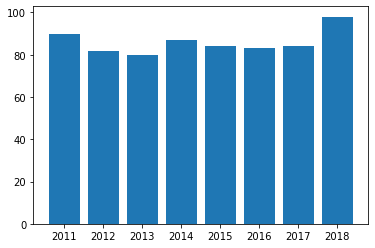

In [144]:
np.count_nonzero(census_data['2018gentrified'])

gentrified_number = np.zeros(8)
for j in range(0,len(RPI)):
    gentrified_number[j] = np.count_nonzero(census_data['{Year}gentrified'.format(Year = Years[j+1])])

plt.bar(Years[1:],gentrified_number)


In [145]:
# Whether eligable

census_data['gentrify_elig'] = 0
income_40_percentile = census_data['2010household_income'].quantile(0.4)
census_data['2010_population_greater_500'] = 0

value_40_percentile = census_data['2010home_value'].quantile(0.4)
value_40_percentile

census_data.loc[(census_data['2010household_income'] <= income_40_percentile) & 
               (census_data['2010home_value'] <= value_40_percentile) &
               (census_data['2010population'] >= 500), 'gentrify_elig'] = 1

In [146]:
for j in range(0,len(RPI)):
    census_data["{Year}gentrified_and_eligable".format(Year = Years[j+1])] = np.where((census_data["gentrify_elig"] ==1) & (census_data['{Year}gentrified'.format(Year = Years[j+1])] == 1) , 1, 0)

<BarContainer object of 8 artists>

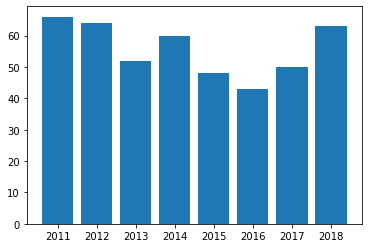

In [147]:
np.count_nonzero(census_data['2018gentrified_and_eligable'])


gentrified_number_and_eligable = np.zeros(8)
for j in range(0,len(RPI)):
    gentrified_number_and_eligable[j] = np.count_nonzero(census_data['{Year}gentrified_and_eligable'.format(Year = Years[j+1])])

plt.bar(Years[1:],gentrified_number_and_eligable)


In [148]:
gentrified_number_and_eligable

array([66., 64., 52., 60., 48., 43., 50., 63.])